Marcin Wardyński  
wtorek, 9:45

## Laboratorium 7
### 7.3 RBM - własna implementacja

Moja implementacja RBM z Contrastive Divergence mocno bazuje na implementacji wykonanej w ramach zajęć: *Sieci neuronowe i uczenie głębokie* w poprzednim semestrze.

Z ciekawszych charakterystyk tej implementacji warto zwrócić uwagę na fakt, że wektory bias-u dla warstwy widocznej oraz ukrytej zostały doklejone do macierzy wag `W`. Zabieg ten upraszcza samą operację uwzględnienia bias-u przy wyliczaniu nowych wag, ale z drugiej strony wymaga odpowiedniego rozszerzania wektorów używanych podczas treningu algorytmem CDk, w tym warstwy widocznej.

In [19]:
import importlib
import lab7_utils as utils
importlib.reload(utils)

import numpy as np
import matplotlib.pyplot as plt

Definiuję kilka funkcji pomocniczych dla samego modelu, jak i dla wizualizacji zmiany jego wag:

In [20]:
import matplotlib.pyplot as plt

def sigmoid(matrix):
    return 1.0 / (1.0 + np.exp(-matrix))

def append_ones(matrix):
    return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=1)

def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def save_tiles(examples, epoch):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = examples[r, c]
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.suptitle(f'Weights at Epoch {epoch}')
    plt.savefig('imgs/image_at_epoch_{:04d}.png'.format(epoch))
    plt.close()    

Sama implementacja RBM opierająca się o algorytm trenujący *Contrastive Diverge* wygląda w następujący sposób:

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

import time

class RBM:
    def __init__(self, visible_dim, hidden_dim):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim

        self.W = np.random.normal(scale=0.01,
                                  size=(self.visible_dim+1, self.hidden_dim+1)).astype(np.float64)
        self.W[:, -1] = 0.0
        self.W[-1, :] = 0.0

    def fit(self, X, epochs=10, batch_dim=50, lr=0.1):
        for epoch in range(epochs):
            print("Epoch {}:".format(epoch + 1),  end="\t")
            
            start_time = time.time()
            self.train_epoch(X, batch_dim, lr)
            
            elapsed = time.time() - start_time
            error = self.reconstuction_error(X)
            print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))
            self.plot_weights(epoch+1)
    
        print("Training finished!")

    def train_epoch(self, dataset, batch_dim, lr):
        batches_limit = dataset.shape[0] / batch_dim
        for batch_idx, batch in enumerate(chunks(dataset, batch_dim)):
            self.cdk(batch, lr)
            if batch_idx % round(batches_limit / 50) == 0: print("#", end="")

    def cdk(self, minibatch, lr, k=3):
        observations_count = minibatch.shape[0]

        positive_visible = minibatch
        negative_visible = append_ones(zeros(observations_count, self.visible_dim))

        positive_hidden = append_ones(zeros(observations_count, self.hidden_dim))
        negative_hidden = append_ones(zeros(observations_count, self.hidden_dim))

        positive_hidden[:, :-1] = sigmoid(positive_visible @ self.W[:, :-1])
        positive_gradient = np.transpose(positive_visible) @ positive_hidden / observations_count 

        negative_hidden[:, :-1] = positive_hidden[:, :-1] > rand(positive_hidden.shape[0], positive_hidden.shape[1] - 1)
        negative_visible[:, :-1] = sigmoid(negative_hidden @ np.transpose(self.W[:-1, :])) > rand(negative_visible.shape[0], negative_visible.shape[1] - 1)

        for _ in range(k-1):
            negative_hidden[:, :-1] = sigmoid(negative_visible @ self.W[:, :-1]) > rand(negative_hidden.shape[0], negative_hidden.shape[1] - 1)
            negative_visible[:, :-1] = sigmoid(negative_hidden @ np.transpose(self.W[:-1, :])) > rand(negative_visible.shape[0], negative_visible.shape[1] - 1)
        negative_hidden[:, :-1] = sigmoid(negative_visible @ self.W[:, :-1])

        negative_gradient = np.transpose(negative_visible) @ negative_hidden / observations_count

        self.W += lr * positive_gradient - lr * negative_gradient

    def reconstuction_error(self, minibatch):
        observations_count = minibatch.shape[0]
        
        reconstructed = self.reconstruct(minibatch)
        error = np.sum((minibatch[:, :-1] - reconstructed) ** 2) / observations_count

        return error
    
    def reconstruct(self, minibatch):
        observations_count = minibatch.shape[0]
        visible = zeros(observations_count, self.visible_dim)
        hidden = append_ones(zeros(observations_count, self.hidden_dim))

        hidden[:, :-1] = sigmoid(minibatch @ self.W[:, :-1]) > rand(hidden.shape[0], hidden.shape[1] - 1)
        visible = sigmoid(hidden @ np.transpose(self.W[:-1, :]))

        return visible

    def plot_weights(self, step=0):
        weights = np.reshape(np.transpose(self.W)[:-1, :-1], newshape=(8, -1, 28, 28))
        weights = np.clip(weights, -1, 1)
        save_tiles(weights, step)

    


Wczytuję zbiór `Fashion MNIST` przy użyciu funkcji pomocniczych:

In [22]:
X_train, X_test, y_train, y_test = utils.get_dataset(dataset_name=utils.Dataset_Select.F_MNIST.value, print_sample_number=0)

a następnie uruchamiam trening dla domyślnych parametrów funcji `fit` oraz warstwy ukrytej o 40 neuronach. Wartość k algorytmu CDk ustawiam na 3.

*Uwaga: Dołączenie jedynek na ostatnich miejscach danych wejściowych potrzebna jest dla uwzględnienia bias-u z macierzy wag*

In [23]:
visible_dim = 28 * 28
hidden_dim = 40

rbm = RBM(visible_dim=visible_dim, hidden_dim=hidden_dim)
dataset = append_ones(X_train)
rbm.fit(dataset)

Epoch 1:	##################################################	elapsed: 2.23s, reconstruction error: 64.78
Epoch 2:	##################################################	elapsed: 2.58s, reconstruction error: 57.01
Epoch 3:	##################################################	elapsed: 2.37s, reconstruction error: 52.94
Epoch 4:	##################################################	elapsed: 2.55s, reconstruction error: 50.84
Epoch 5:	##################################################	elapsed: 2.51s, reconstruction error: 49.52
Epoch 6:	##################################################	elapsed: 2.62s, reconstruction error: 48.77
Epoch 7:	##################################################	elapsed: 2.71s, reconstruction error: 48.30
Epoch 8:	##################################################	elapsed: 2.67s, reconstruction error: 47.89
Epoch 9:	##################################################	elapsed: 2.47s, reconstruction error: 47.62
Epoch 10:	##################################################	ela

Jak widzimy algorytm działa dość szybko, a wartość błędu rekonstrucji w każdej kolejnej epoce jest mniejsza, czyli model zachowuje zbieżność w trakcie uczenia.

Zwizualizujmy zatem przebieg kształtowania się wag podczas uczenia: 

In [24]:
import glob
import imageio.v2 as imageio
import tensorflow_docs.vis.embed as embed

def create_and_store_gif(anim_file):
    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob('imgs/image*.png')
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)


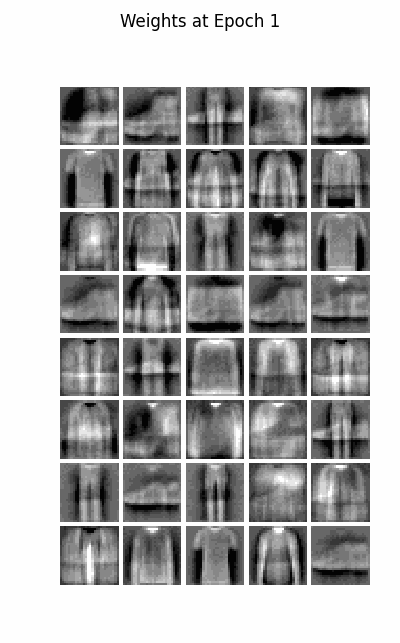

In [25]:
gif_file = 'imgs/weights.gif'
create_and_store_gif(gif_file)
embed.embed_file(gif_file)

Obserwując rozkład wag dla poszczególnych neuronów warstwy ukrytej względem warstwy widocznej można zauważyć, że wizualizacja tych wag przypomina różne elementy zbioru danych `Fashion-MNIST`. Co więcej, z każdą epoką obraz przedmiotu staje się coraz bardziej wyraźny.  
Generalnie analiza wizualizacji przedstawionych wag dla poszczególnych neuronów warstwy ukrytej jest bardzo zbieżna z tą z notatnika 7.1, z tą jednak różnicą, że na powyższym obrazku, w dużej mierze fragmenty grafik zawierających tło otrzymują wagi niemalże zerowe. A przynajmniej tak mi się wydaje, że w tym zadaniu można zauważyć znacznie więcej czerni na reprezentacji wag, niż w zadaniu 7.1.

Kolejne dwie funkcje przedstawiają graficznie efekt rekonstrukcji oraz obliczają wskaźnik SSIM:

In [8]:
def plot_reconstruction(original, reconstructed):
    num_images = min(10, original.shape[0])
    size = original.shape[1]
    plt.figure(figsize=(20, 4))

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].reshape(int(np.sqrt(size)), -1), cmap='gray')
        plt.title(f"Orig {i}")
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].reshape(int(np.sqrt(size)), -1), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.show()

def compute_ssim(original, reconstructed):
    data_range = 1.0
    num_images = original.shape[0]
    size = original.shape[1]
    ssim_values = []
    for i in range(num_images):
        orig_img = original[i].reshape(int(np.sqrt(size)), -1)
        recon_img = reconstructed[i].reshape(int(np.sqrt(size)), -1)
        ssim_values.append(ssim(im1=orig_img, im2=recon_img, data_range=data_range))
    return np.mean(ssim_values)

Wybieram po jednej grafice z każej kategorii i przeprowadzam rekonstrukcję.

In [9]:
all_cats_reps_ids = [27, 2, 16, 13, 6, 8, 4, 9, 18, 0]
print(np.array(y_test)[all_cats_reps_ids])

test_dataset = append_ones(X_test)
all_cats_reps = test_dataset[all_cats_reps_ids]
reconstructed_all_cats_reps = rbm.reconstruct(all_cats_reps)

[0 1 2 3 4 5 6 7 8 9]


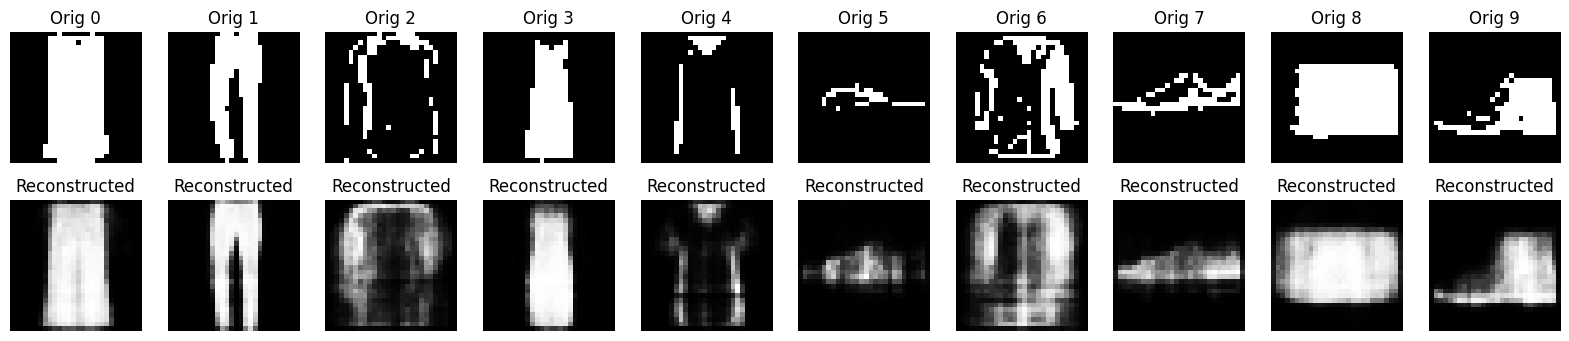

In [10]:
plot_reconstruction(all_cats_reps[:, :-1], reconstructed_all_cats_reps)

Przy reprentacji wizualnej widać podobieństwo oryginału oraz rekonstrukcji. Czym prostszy kształt oryginału, tym lepiej dla rekonstrukcji, co widać dla kategorii 0, 1, 3, oraz 8. Czym więcej wąskich białych elementow, tym rekonstrukcja jest bardziej niewyraźna, jak w przypadku grafik 2, 4, 5 oraz 7.

Generalnie, można powiedzieć o rekonstrukcji, że daje bardzo rozmazane wyniki.

In [11]:
compute_ssim(all_cats_reps[:, :-1], reconstructed_all_cats_reps)

np.float64(0.5285589711841038)

Pomiar SSIM o uśrednionej wartości 0.53 wskazuje na średnią jakość dopasowania z tendencją do słabej.

Myślę, że za słabą jakość rekonstrukcji odpowiada zbyt mała pojemność modelu, dlatego też w kolejnych punktach przeprowadzę jeszcze jeden trening, tym razem używając RBM o warstwie ukrytej zawierającej 256 neuronów. Dla tak powiększonego modelu, zwiększam długość treningu do 100 epok.

In [17]:
rbm = RBM(visible_dim=visible_dim, hidden_dim=256)
dataset = append_ones(X_train)
rbm.fit(dataset, epochs=100)

Epoch 1:	##################################################	elapsed: 3.70s, reconstruction error: 38.50
Epoch 2:	##################################################	elapsed: 3.82s, reconstruction error: 32.59
Epoch 3:	##################################################	elapsed: 4.11s, reconstruction error: 29.98
Epoch 4:	##################################################	elapsed: 3.97s, reconstruction error: 28.54
Epoch 5:	##################################################	elapsed: 3.81s, reconstruction error: 27.42
Epoch 6:	##################################################	elapsed: 3.93s, reconstruction error: 26.62
Epoch 7:	##################################################	elapsed: 3.96s, reconstruction error: 26.05
Epoch 8:	##################################################	elapsed: 3.87s, reconstruction error: 25.69
Epoch 9:	##################################################	elapsed: 4.00s, reconstruction error: 25.28
Epoch 10:	##################################################	ela

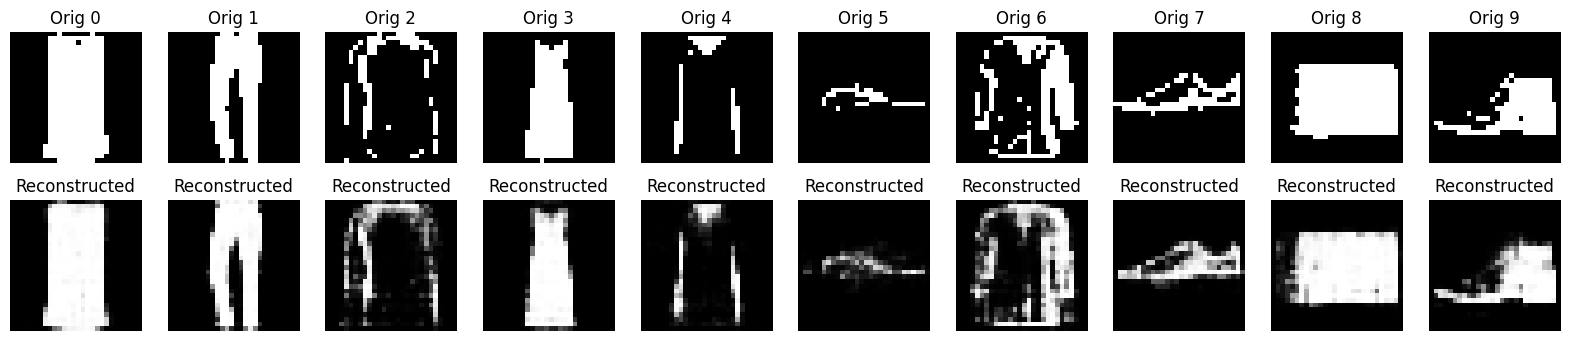

np.float64(0.7894349095803779)

In [18]:
better_reconstructed_all_cats_reps = rbm.reconstruct(all_cats_reps)
plot_reconstruction(all_cats_reps[:, :-1], better_reconstructed_all_cats_reps)
compute_ssim(all_cats_reps[:, :-1], better_reconstructed_all_cats_reps)

Jak widzimy, wyniki dla pojemniejszego modelu trenowanego dłuższy czas są dużo lepsze. Wizualizacje rekonstrukcji są dużo mniej rozmazane a wskaźnik SSIM o wartości 0.79 wskazuje na bardzo dobre odwzorowanie oryginałów przez rekonstrukcje.